In [1]:
import os
import glob
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "SF Pro Display"

In [2]:
DATA_DIR = os.path.join(os.getcwd(), "data")

TRAIN_PERIOD = pd.date_range("2011-01-05", "2017-12-31", freq="10D")
TEST_PERIOD = pd.date_range("2018-05-01", "2019-12-31", freq="10D")
BASELINE_DATE = pd.to_datetime("2002-05-21")

CONFIG = [20, 1, 5, 10, 30]


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

FACTORS = [
    "valuation",
    "profitability",
    "growth",
    "quality",
    "liquidity",
    "momentum_and_reversal",
]


class Stock:
    def __init__(self, name, df_price: pd.DataFrame, df_stats: pd.DataFrame):
        self.name = name
        self.df = df_price
        self.dfStatRaw = df_stats.sort_values(by="Date")
        self.dfStat = self.interpolateStats(self.dfStatRaw)

    def __str__(self):
        return self.name

    # Calculate the factor score for a given time
    def calcFactor(self, factor, currentTime):
        dfTime = self.df[self.df["Date"] <= pd.to_datetime(currentTime)].tail(1)
        dfStatTime = self.dfStat[
            self.dfStat["Date"] <= pd.to_datetime(currentTime)
        ].tail(1)
        if factor == "size":
            return dfStatTime.iloc[0]["SIZE"]
        elif factor == "valuation":
            return dfStatTime.iloc[0]["PBR"]
        elif factor == "profitability":
            return dfStatTime.iloc[0]["ROE"]
        elif factor == "growth":
            return dfStatTime.iloc[0]["GROWTH"]
        elif factor == "quality":
            return dfStatTime.iloc[0]["Current Ratio"]
        elif factor == "liquidity":
            return dfTime.iloc[0]["ILLIQ"]
        elif factor == "momentum_and_reversal":
            return self.calcReturn(currentTime, 60)
        else:
            return None

    # Calculate the return for a given time
    def calcReturn(self, currentTime, timeFrame):
        now = (
            self.df[self.df["Date"] <= pd.to_datetime(currentTime)]
            .tail(1)
            .iloc[0]["Close"]
        )
        next = (
            self.df[
                self.df["Date"]
                <= pd.to_datetime(currentTime) + pd.Timedelta(timeFrame, unit="d")
            ]
            .tail(1)
            .iloc[0]["Close"]
        )
        return (next - now) * 100 / now

    # Interpolate the missing values in the stats dataframe
    def interpolateStats(self, df: pd.DataFrame):
        df = df.set_index("Date")
        try:
            df = df.reindex(
                pd.date_range(
                    start=df.index.min(),
                    end=df.index.max(),
                    freq="D",
                )
            )
        except:
            print(self.name)
            print(df.index.min(), df.index.max())
            print(df)
            sys.exit()
        df = df.interpolate(method="cubicspline", axis=0)
        df = df.reset_index()
        df = df.rename(columns={"index": "Date"})
        return df


class Indicator:
    def __init__(self, name, df: pd.DataFrame):
        self.name = name
        self.df = df

    def __str__(self):
        return self.name

    def calcIndicator(self, currentTime):
        return (
            self.df[self.df["DATE"] <= pd.to_datetime(currentTime)].tail(1).iloc[0, 1]
        )

    def calcYoY(self, currentTime):
        now = self.calcIndicator(currentTime)
        lastYear = self.calcIndicator(currentTime - pd.Timedelta(365, unit="d"))
        return (now - lastYear) * 100 / lastYear

    def calcMoM(self, currentTime):
        now = self.calcIndicator(currentTime)
        lastMonth = self.calcIndicator(currentTime - pd.Timedelta(30, unit="d"))
        return (now - lastMonth) * 100 / lastMonth


class StockPile:
    def __init__(self, name="StockPile", index: pd.DataFrame = None):
        self.name = name
        self.stocks = []
        self.indicators = []
        self.index = index

    def __str__(self):
        return self.name

    def addStock(self, stock: Stock):
        self.stocks.append(stock)

    def addIndicator(self, indicator):
        self.indicators.append(indicator)

    def getIndex(self, currentTime):
        return (
            self.index[self.index["Date"] <= pd.to_datetime(currentTime)]
            .tail(1)
            .iloc[0]["Close"]
        )

    def getIndicators(self, currentTime):
        return (
            [i.calcIndicator(currentTime) for i in self.indicators]
            + [i.calcYoY(currentTime) for i in self.indicators]
            + [i.calcMoM(currentTime) for i in self.indicators]
            + [self.getIndex(currentTime)]
        )

    # Calculate the IC for a given factor in a given time
    def calcIC(self, factor, currentTime, timeFrame=10, verbose=False):
        fact = []
        alpha = []
        for stock in self.stocks:
            try:
                _fact = stock.calcFactor(factor, currentTime)
            except:
                continue
            if not np.isnan(_fact):
                fact.append(_fact)
                alpha.append(stock.calcReturn(currentTime, timeFrame))
        if verbose:
            print(fact)
            print(alpha)
            print(len(fact), len(alpha))

        return np.corrcoef(fact, alpha)[0, 1]

    def showICScatter(self, currentTime, timeFrame=10, verbose=False):
        for i in range(len(FACTORS)):
            plt.subplot(2, 3, i + 1)
            fact = []
            alpha = []
            stocks = []
            for stock in self.stocks:
                try:
                    _fact = stock.calcFactor(FACTORS[i], currentTime)
                except:
                    continue
                if not np.isnan(_fact):
                    fact.append(_fact)
                    alpha.append(stock.calcReturn(currentTime, timeFrame))
                    stocks.append(stock)
            plt.scatter(fact, alpha)
            plt.title(
                f"{FACTORS[i]} IC: {self.calcIC(FACTORS[i], currentTime, timeFrame).round(3)}"
            )
            plt.xlabel("Factor Score")
            plt.ylabel("Return")
            if verbose:
                print(
                    pd.DataFrame(
                        {
                            "Stock": stocks,
                            "{}".format(FACTORS[i]): fact,
                            "Return": alpha,
                        }
                    )
                )
        plt.suptitle(f"IC Scatter Plot for {self.name} at {currentTime.date()}")
        plt.tight_layout()
        plt.show()

    # Calculate the ICs for a given factor in a given time
    # 1 day IC, 5 day IC, 10 day IC
    def calcICBulk(self, currentTime, config):
        IC = []
        for timeFrame in config:
            IC += [self.calcIC(factor, currentTime, timeFrame) for factor in FACTORS]
        return IC


# Create a dataframe of ICs for a given stockpile
def createICDataFrame(stockPile, period, config=None):
    ic = []
    nextic = []
    date = []
    delta = (period[1] - period[0]).days
    window = 5

    if config is None:
        config = [1, 5, 10]

    def return20D(currentTime):
        now = stockPile.getIndex(currentTime)
        next = stockPile.getIndex(currentTime + pd.Timedelta(20, unit="d"))
        return (next - now) * 100 / now

    for i in trange(len(period)):
        if i < window:
            continue
        currentTime = period[i]
        IC_append = []
        nextIC_append = stockPile.calcICBulk(
            currentTime + pd.Timedelta(20, unit="d"), [20]
        )
        for j in range(window):
            IC_append += stockPile.calcICBulk(period[i - j], config)
        IC_append += [return20D(currentTime)]
        IC_append += stockPile.getIndicators(currentTime)
        date.append(currentTime)
        ic.append(IC_append)
        nextic.append(nextIC_append)

    Date = pd.DataFrame(date, columns=["Date"])
    col = []
    for _window in range(window):
        for timeFrame in config:
            col += [
                "{}_{}d_{}".format(factor, timeFrame, _window) for factor in FACTORS
            ]
    IC_output = pd.DataFrame(
        ic,
        columns=col
        + ["20 Day Return"]
        + [i.name for i in stockPile.indicators]
        + ["{} YoY".format(i.name) for i in stockPile.indicators]
        + ["{} MoM".format(i.name) for i in stockPile.indicators]
        + ["Index"],
    )
    nextIC_output = pd.DataFrame(nextic, columns=FACTORS)
    icwithdate = pd.concat([Date, IC_output.iloc[:, 0:6]], axis=1)
    icwithdate.set_index("Date", inplace=True)
    icwithdate = icwithdate.sub(icwithdate.min(axis=1), axis=0).div(
        icwithdate.max(axis=1) - icwithdate.min(axis=1), axis=0
    )
    icwithdate = icwithdate.div(icwithdate.sum(axis=1), axis=0)
    return IC_output, nextIC_output, icwithdate


In [4]:
stocks = [
    "AXP",
    "AMGN",
    "AAPL",
    "BA",
    "CAT",
    "CSCO",
    "CVX",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC",
    "JNJ",
    "KO",
    "JPM",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "CRM",
    "VZ",
    "V",
    "WBA",
    "WMT",
    "DIS",
]
djia = pd.read_csv(os.path.join(DATA_DIR, "indices", "DJIA.csv"), parse_dates=["Date"])
dow30 = StockPile("DOW30", djia)

for stock in stocks:
    df_price = pd.read_csv(
        os.path.join(DATA_DIR, "stocks", f"{stock}.csv"), parse_dates=["Date"]
    )
    df_stats = pd.read_csv(
        os.path.join(DATA_DIR, "financials", f"{stock}_STAT.csv"), parse_dates=["Date"]
    )
    df_price["Date"].dropna(inplace=True)
    df_stats["Date"].dropna(inplace=True)
    dow30.addStock(Stock(stock, df_price, df_stats))

for indicator in glob.glob(os.path.join(DATA_DIR, "indicators", "*.csv")):
    df_indicator = pd.read_csv(indicator, parse_dates=["DATE"])
    dow30.addIndicator(Indicator(os.path.basename(indicator)[:-4], df_indicator))


In [5]:
for indicator in dow30.indicators:
    print(indicator.name)

CPI_TOTAL
CPI
GOVTBOND10
JOBVAC
DFF
INDPRO
UNRATE
HOUST
IPFPNSS
IPFINAL
IPMAN
CLI
FEDFUNDS
M3
GDP


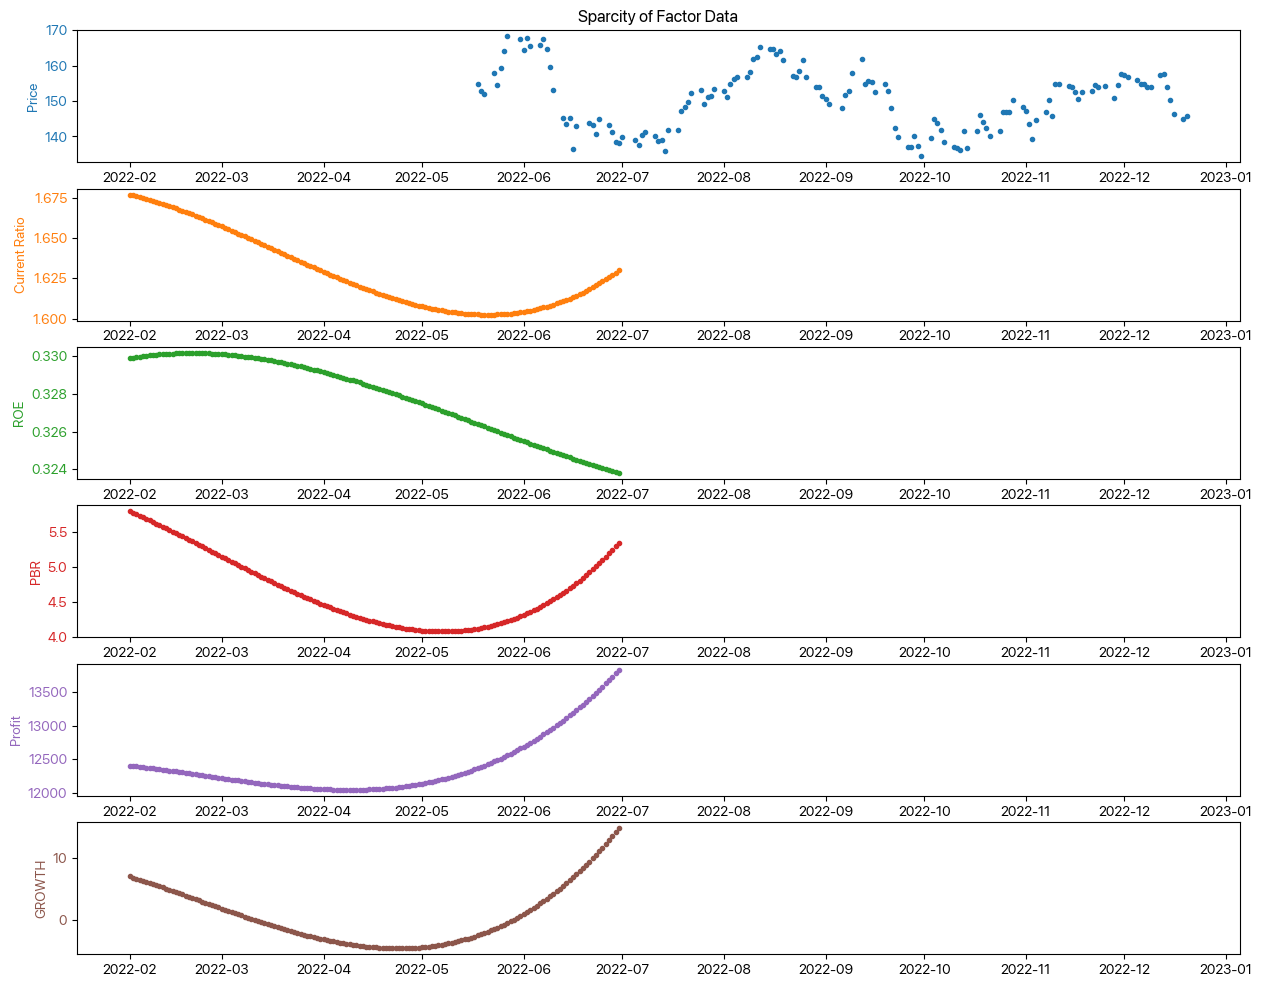

In [6]:
# Plot Price and stats in multiple axis
preview = 150

fig = plt.figure(figsize=(15, 12))
ax = plt.subplot(6, 1, 1)
ax.scatter(
    dow30.stocks[0].df["Date"].tail(preview),
    dow30.stocks[0].df["Close"].tail(preview),
    marker=".",
    label="Price",
    color="tab:blue",
)
ax.set_ylabel("Price", color="tab:blue")
ax.tick_params(axis="y", labelcolor="tab:blue")
ax.set_title("Sparcity of Factor Data")
colors = ["tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
colors.reverse()
for factor in dow30.stocks[0].dfStat.columns[1:]:
    color = colors.pop()
    plt.subplot(6, 1, (6 - len(colors)), sharex=ax)
    plt.plot(
        dow30.stocks[0].dfStat["Date"].tail(preview),
        dow30.stocks[0].dfStat[factor].tail(preview),
        ".",
        label=factor,
        color=color,
    )
    plt.ylabel(factor, color=color)
    plt.tick_params(axis="y", labelcolor=color)


In [7]:
dow30.calcIC("valuation", "2016-01-08", verbose=True)

[2.5290215955298363, 3.636407798187487, 4.165768359625289, 12.08234979999386, 1.9380465963667894, 1.6031380174301872, 0.8392197021776572, 0.6720278984980487, 21.432527329924547, 3.669366145354368, 6.416217929506376, 2.1893844039207098, 3.34609851146913, 5.826661013710072, 0.7988306636573129, 6.474738109339469, 6.490072265098862, 2.6547999622104315, 5.214958204644092, 7.857793714238871, 2.8463857364537684, 1.2066912005890242, 2.9986033917976966, 9.041713817722789, 7.630656956473073, 2.346239798898601, 1.9046036001969868, 3.506955374216612]
[-1.13154071142545, 0.391491443148327, 0.17532159841246198, -3.354104312390872, -4.21934077743695, -4.681211583502766, 1.87506210301961, -5.081111276816779, -3.769155062485118, -1.1886761509316137, -1.2155284810347446, -5.553822408673363, -1.1817271128460953, -0.024099843259034682, -3.1907763305723846, -0.2598015503329971, -1.2812770914214233, 0.11746188156168554, -2.5606707120990335, -2.2252416437021836, -1.303163224538547, -0.8396964725246928, -0.80

-0.10995890949754224

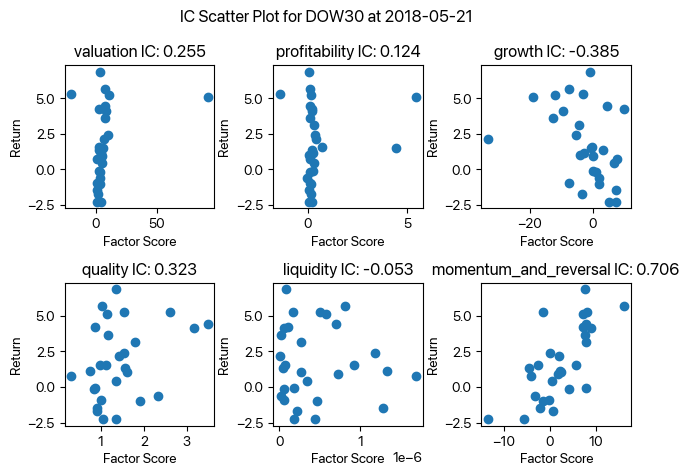

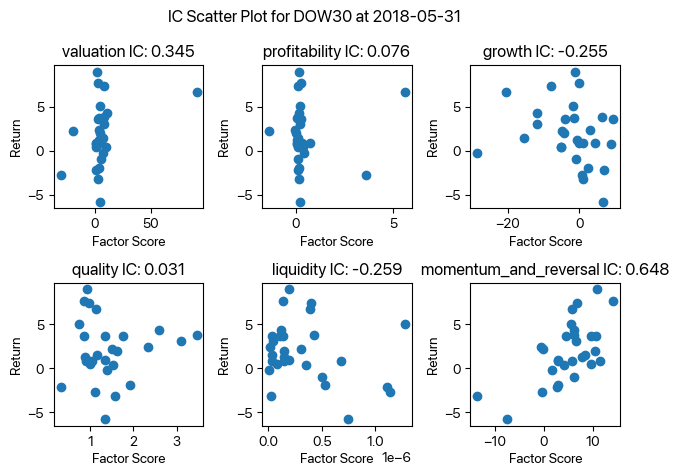

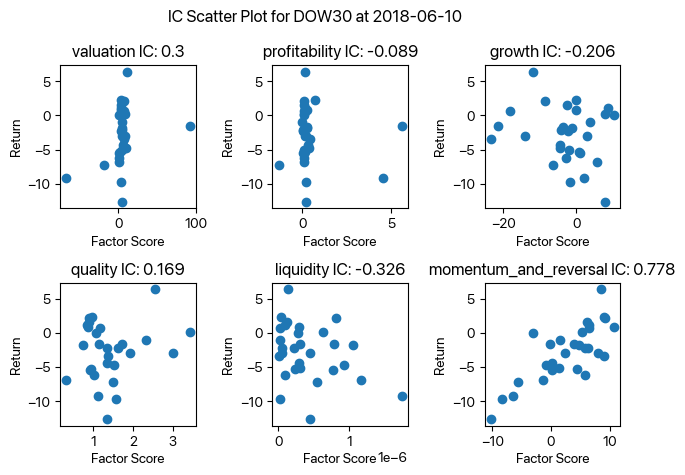

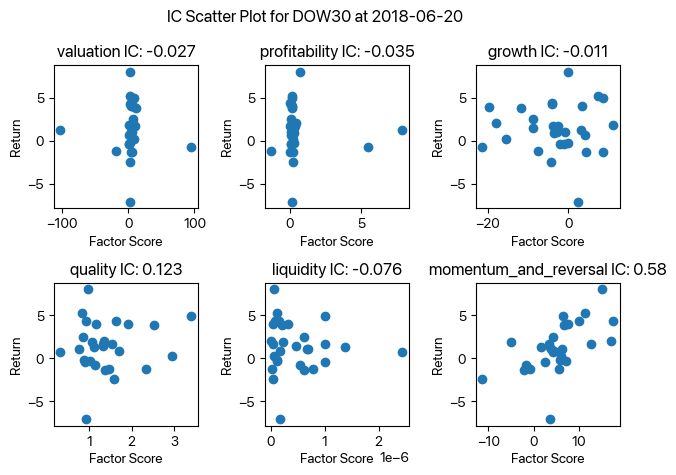

In [8]:
# Scatter IC
for period in TEST_PERIOD[:4]:
    dow30.showICScatter(period + pd.Timedelta(20, unit="d"), 20)

In [9]:
# Train Dataset
IC_train, nextIC_train, icwithdate = createICDataFrame(dow30, TRAIN_PERIOD, CONFIG)


  0%|          | 0/256 [00:00<?, ?it/s]/Users/thkim/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/thkim/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 256/256 [24:50<00:00,  5.82s/it]


In [10]:
IC_train

,valuation_20d_0,profitability_20d_0,growth_20d_0,quality_20d_0,liquidity_20d_0,momentum_and_reversal_20d_0,valuation_1d_0,profitability_1d_0,growth_1d_0,quality_1d_0,...,UNRATE MoM,HOUST MoM,IPFPNSS MoM,IPFINAL MoM,IPMAN MoM,CLI MoM,FEDFUNDS MoM,M3 MoM,GDP MoM,Index
0,-0.294666,-0.068123,-0.017034,0.215438,0.097706,0.478187,0.445295,-0.006632,-0.321964,0.231787,...,-1.098901,-17.936508,-0.118009,-0.108939,0.214165,0.081123,-5.882353,0.723102,0.000000,12068.50000
1,0.022287,0.169882,0.096160,-0.327787,0.350449,0.476615,-0.241016,-0.039068,0.016650,-0.121357,...,0.000000,16.054159,0.202466,0.104441,0.680882,-0.009797,-12.500000,0.636893,0.000000,12169.87988
2,0.166948,0.128695,-0.018157,-0.387894,0.218942,0.204545,-0.432188,-0.030887,0.007118,0.053524,...,0.000000,16.054159,0.202466,0.104441,0.680882,-0.009797,-12.500000,0.636893,0.000000,11613.29981
3,0.061728,-0.243568,-0.074928,0.079433,-0.116200,0.677654,NaN,NaN,NaN,NaN,...,0.000000,16.054159,0.202466,0.104441,0.680882,-0.009797,-12.500000,0.636893,0.000000,12220.58984
4,0.154742,0.080487,-0.345276,0.106345,-0.289315,0.864111,-0.349011,-0.031173,0.216473,0.211955,...,1.111111,-7.666667,-0.191113,-0.218297,-0.593620,-0.101627,-28.571429,0.686532,1.342486,12393.90039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0.401573,0.298576,0.006070,-0.031828,0.396008,0.691793,0.337968,0.181443,-0.025043,-0.039975,...,0.000000,1.272872,-0.102188,-0.250285,0.029578,0.085458,0.869565,0.193796,0.000000,23358.24023
247,0.428787,0.497633,0.178707,-0.013111,-0.023823,0.545306,0.251049,0.304397,0.129945,0.049571,...,0.000000,1.272872,-0.102188,-0.250285,0.029578,0.085458,0.869565,0.193796,0.000000,23940.67969
248,0.199646,0.134395,0.030523,-0.168718,-0.284415,0.352120,NaN,NaN,NaN,NaN,...,-2.380952,-7.541241,0.185058,0.189647,-0.298773,0.080094,12.068966,0.349172,0.000000,24329.16016
249,0.203754,0.155545,-0.001622,0.130365,-0.114100,0.405850,0.243913,0.098785,0.020477,0.086825,...,-2.380952,-7.541241,0.185058,0.189647,-0.298773,0.080094,12.068966,0.349172,0.000000,24754.75000


In [11]:
print(IC_train.shape)

(251, 197)


In [12]:
# Test Dataset
IC_test, nextIC_test, icwithdate_test = createICDataFrame(dow30, TEST_PERIOD, CONFIG)
print(IC_test.shape, nextIC_test.shape)

  0%|          | 0/61 [00:00<?, ?it/s]/Users/thkim/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/thkim/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 61/61 [05:40<00:00,  5.59s/it]

(56, 197) (56, 6)


In [13]:
# IC Graph Generation
# icwithdate.plot.area(
    # figsize=(20, 5),
    # legend=True,
    # colormap="tab10",
    # title="IC Weights over training period",
# )
# plt.savefig(dpi=300, fname="icweights.png")


In [14]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

xgbModel = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=300,
        learning_rate=0.03,
        max_depth=5,
        min_child_weight=2,
        gamma=0,
        subsample=0.2,
        colsample_bylevel=0.6,
        colsample_bytree=0.2,
        reg_lambda=20,
        tree_method="hist",
    )
)

In [15]:
# Model Training
print(IC_train.shape, nextIC_train.shape)
xgbModel.fit(IC_train, nextIC_train)
print(xgbModel.score(IC_train, nextIC_train))


(251, 197) (251, 6)
0.5787143430556281


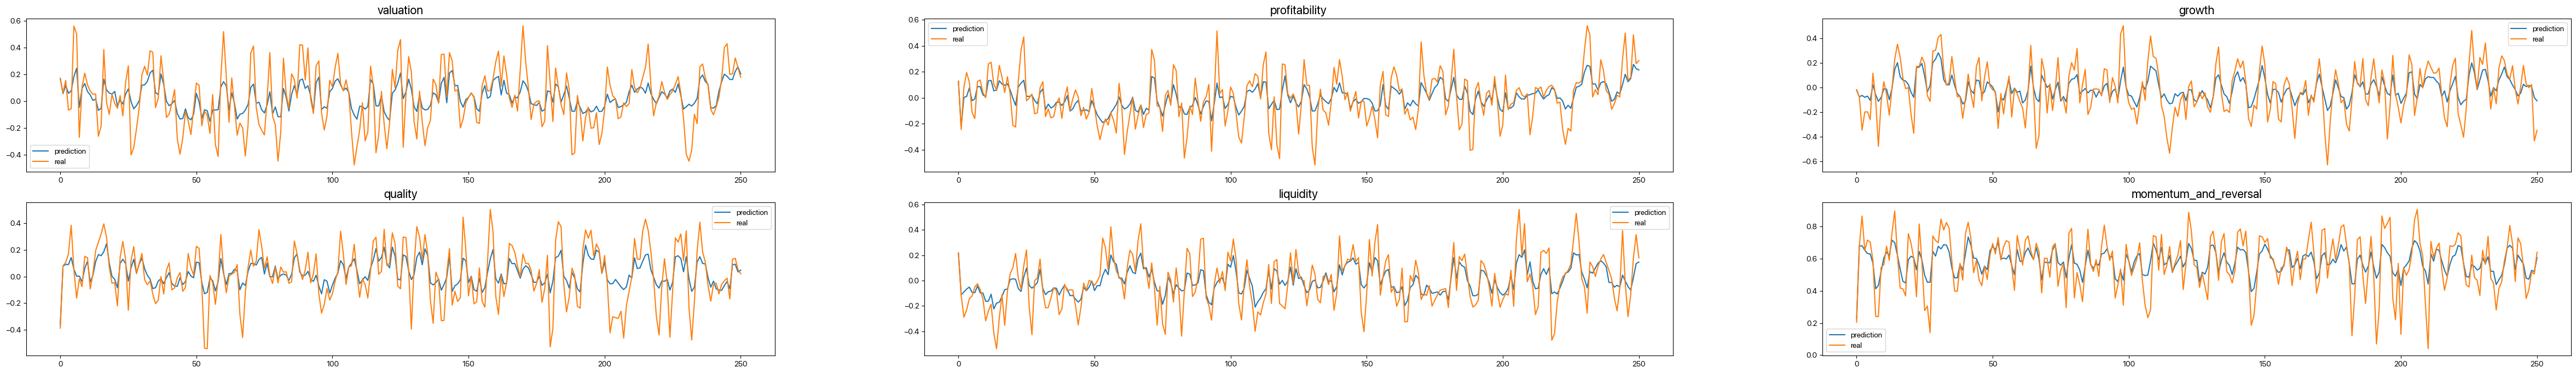

In [16]:
plt.figure(figsize=(60, 8))
IC_predict_train = pd.DataFrame(xgbModel.predict(IC_train), columns=FACTORS)
for i in range(len(FACTORS)):
    plt.subplot(2, 3, i + 1)
    plt.title(FACTORS[i], fontsize=16)
    plt.plot(IC_predict_train.iloc[:, i], label="prediction")
    plt.plot(nextIC_train.iloc[:, i], label="real")
    plt.legend()

plt.savefig(dpi=300, fname = "prediction.png")

In [17]:
print(xgbModel.score(IC_test, nextIC_test))


-0.25627192577649666


-0.25627192577649666


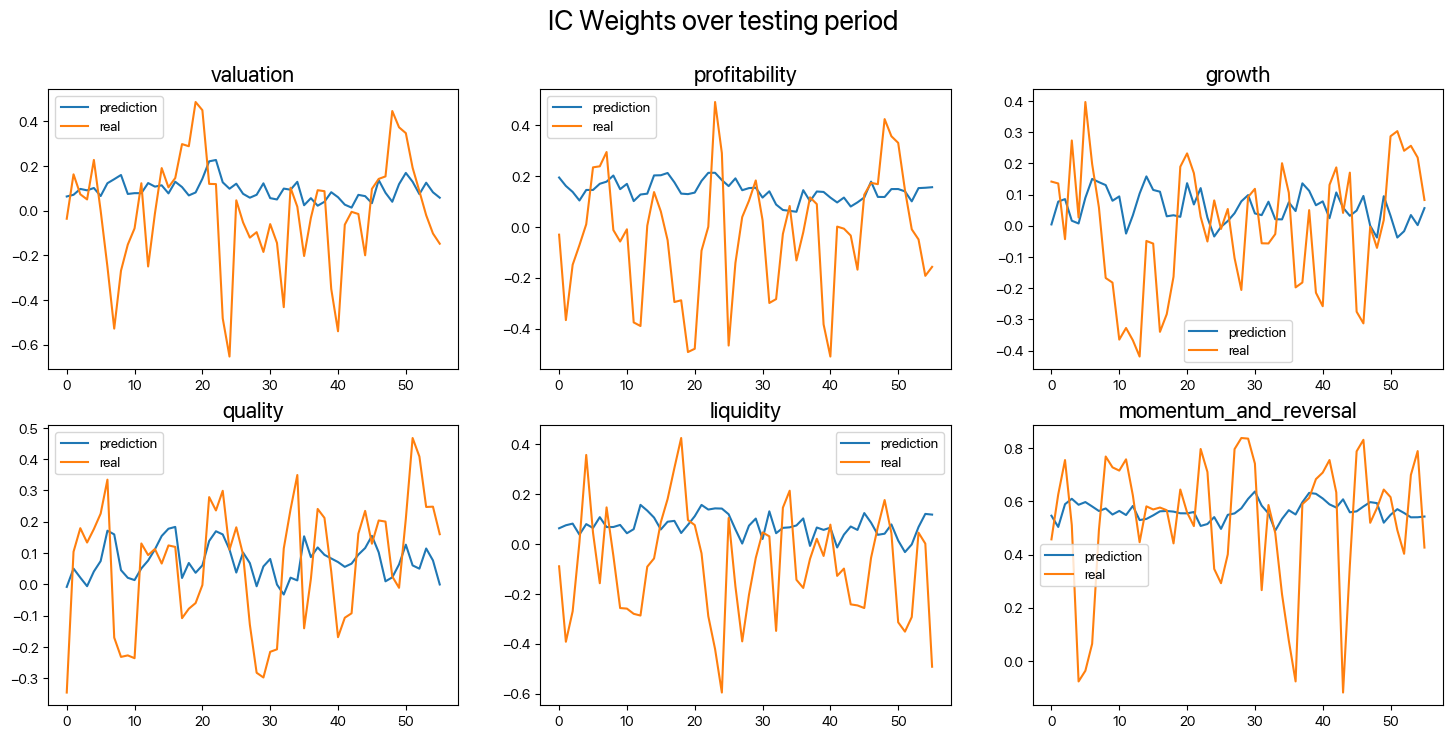

In [18]:
# Model Testing
print(xgbModel.score(IC_test, nextIC_test))
plt.figure(figsize=(18, 8))
plt.suptitle("IC Weights over testing period", fontsize=20)
IC_predict = pd.DataFrame(xgbModel.predict(IC_test), columns=FACTORS)
for i in range(len(FACTORS)):
    plt.subplot(2, 3, i + 1)
    plt.title(FACTORS[i], fontsize=16)
    plt.plot(IC_predict.iloc[:, i], label="prediction")
    plt.plot(nextIC_test.iloc[:, i], label="real")
    plt.legend()

plt.savefig(dpi=300, fname = "prediction.png")